In [2]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 10.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 25.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [1]:
pip install rdkit-pypi

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap
import seaborn as sns
import os 


from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors


from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.svm import SVR


### import the smiles_tg.csv file into a dataframe and identify how many unique smiles strings are in the dataset

In [2]:
df = pd.read_csv("smiles_tg.csv")

print(f"Liczba wszystkich wpisów: {len(df)}")
print(f"Liczba unikalnych SMILES: {df['SMILES'].nunique()}")

Liczba wszystkich wpisów: 966
Liczba unikalnych SMILES: 964


In [5]:
df.head()

,SMILES,tg
0,*C1COC2C1OCC2Oc1ccc(cc1)CNC(=O)CCCCCCC(=O)NCc1...,21.581731
1,*OC(CCC(OC(=O)Nc1ccc(cc1)Cc1ccc(cc1)NC(=O)*)C)C,63.589338
2,*OC(=O)c1ccc(cc1)C(=O)OCCCC(=O)NCc1ccc(cc1)CNC...,53.557261
3,*OC(=O)NCCNC(=O)OCC*,5.896093
4,*SCCCCC*,-55.378610


### drop the duplicate smiles strings in the dataset, keep the first entry and reset the index

In [3]:
df_unique = df.drop_duplicates(subset='SMILES', keep='first').reset_index(drop=True)
print(f"Liczba po usunięciu duplikatów: {len(df_unique)}")

Liczba po usunięciu duplikatów: 964


### we are going to use the RDKit library to convert the smiles strings into molecular objects that we will use as features for our models
### lets first generate basic descriptors for the molecules
### here you will write a basic function called get_basic_descriptors, that takes a smiles string as input, and returns a dictionary of descriptors the descriptors are the following:

### 'MW': molecular weight
 
### 'HBD': number of hydrogen bond donors

### 'HBA': number of hydrogen bond acceptors

### 'TPSA': topological polar surface area

### 'Rotatable_Bonds': number of rotatable bonds

In [7]:
def get_basic_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    descriptors = {
        'MW': Descriptors.MolWt(mol),
        'HBD': rdMolDescriptors.CalcNumHBD(mol),
        'HBA': rdMolDescriptors.CalcNumHBA(mol),
        'TPSA': rdMolDescriptors.CalcTPSA(mol),
        'Rotatable_Bonds': Descriptors.NumRotatableBonds(mol)
    }
    return descriptors

In [8]:
# Przykład
example_smiles = "CCO"

# Oblicz deskryptory
desc = get_basic_descriptors(example_smiles)
print(desc)

{'MW': 46.069, 'HBD': 1, 'HBA': 1, 'TPSA': 20.23, 'Rotatable_Bonds': 0}


next create a function called get_morgan_fingerprint that takes in smiles strings and generates morgan fingerprints

with a radius of 2 and a length nBits= 1024

Return the fingerprint as a list

hint: the Input parameters to the function should be

smiles, radius, nBits

the function should return the fingerprint as a list

this can be done in a very few lines of code (don't complicate it)

In [9]:
# Przykład
smiles = "CCO"  # etanol
mol = Chem.MolFromSmiles(smiles)

print(mol)
print(Descriptors.MolWt(mol))

46.069


next create a function called get_morgan_fingerprint that takes in smiles strings and generates morgan fingerprints

with a radius of 2 and a length nBits= 1024

Return the fingerprint as a list

hint: the Input parameters to the function should be

smiles, radius, nBits

the function should return the fingerprint as a list

this can be done in a very few lines of code (don't complicate it)

In [10]:
def get_morgan_fingerprint(smiles, radius=2, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Nieprawidłowy SMILES")

    fpgen = GetMorganGenerator(radius=radius,fpSize=nBits)
    fp = fpgen.GetFingerprint(mol)
    return list(fp.ToBitString())

In [11]:
# Przykład
smiles = "CC(=O)O"  # etanol
fingerprint = get_morgan_fingerprint(smiles, radius=2, nBits=1024)

print(fingerprint[:10])  # pokaż pierwsze 10 bitów

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


In [12]:
print(get_morgan_fingerprint("*c1cccc(-c2nc3ccccc3c(-c3ccc(Oc4ccc(-c5c(-c6ccccc6)c(*)nc6ccccc56)cc4)cc3)c2-c2ccccc2)c1")[:10])

['0', '0', '0', '1', '0', '0', '0', '0', '0', '0']


In [13]:
print(get_morgan_fingerprint("*Oc1ccc(C2(c3ccc(OC(*)=O)cc3)CC3CCC2C3)cc1")[:10])

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


In [14]:
print(get_morgan_fingerprint("*c1cccc(C(=O)c2cccc(N3C(=O)c4ccc(C(c5ccc6c(c5)C(=O)N(*)C6=O)(C(F)(F)F)C(F)(F)F)cc4C3=O)c2)c1")[:10])

['0', '0', '0', '0', '0', '0', '0', '0', '0', '1']


Next create a function called get_topological_fingerprint that generates topological fingerprints from SMILES strings. These fingerprints capture the 2D structural features of molecules.

The function should take in a smiles string and nBits=25

return the fingerprint as a list

In [15]:
def get_topological_fingerprint(smiles, nBits=25):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Nieprawidłowy SMILES")

    fp = RDKFingerprint(mol,fpSize=nBits)
    return list(fp.ToBitString())

In [16]:
from rdkit.Chem import RDKFingerprint

In [17]:
smiles = "CCO"  # etanol
fingerprint = get_topological_fingerprint(smiles, nBits=25)
print(fingerprint)

['1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1']


In [18]:
print(get_topological_fingerprint("*c1cccc(-c2nc3ccccc3c(-c3ccc(Oc4ccc(-c5c(-c6ccccc6)c(*)nc6ccccc56)cc4)cc3)c2-c2ccccc2)c1")[:25])

['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1']


we are now going to use these functions to generate features for our models.

lets start with the get_basic_descriptors function, use it to convert the smiles strings in the dataset to features

so what you will do here is create a list that contains the descriptors for each smiles string in the dataset

remember, in your function, this should return a dictionary of descriptors, so you will have a single list, where each smile string is represented by a dictionary of descriptors

if you did this correctly and print the output, the first entry should look similar to this:

[{'MW': 167.188, 'HBD': 0, 'HBA': 5, 'TPSA': 75.99, 'Rotatable_Bonds': 0},{.....}]

In [19]:
features_list = [get_basic_descriptors(smiles) for smiles in df_unique['SMILES']]

In [21]:
print(features_list[664])

{'MW': 54.09199999999999, 'HBD': 0, 'HBA': 0, 'TPSA': 0.0, 'Rotatable_Bonds': 2}


In [19]:
print(features_list[3])


{'MW': 174.15599999999998, 'HBD': 2, 'HBA': 4, 'TPSA': 76.66000000000001, 'Rotatable_Bonds': 5}


convert this list of dictionaries into a dataframe called df_descriptors

next lets scale the features using the StandardScaler from sklearn.preprocessing

fit and transform the dataframe and we'll call this scaled dataframe X

now that your data is transformed, use KMeans clustering to cluster and fit the scaled dataframe (X).

use n_clusters = 5, and a random_state = 0

extract the labels using kmeans.labels_ and add this as a column a new column in the df_descriptors called 'cluster'

next use the PCA algorithmn to reduce the dimensionality of the dataframe (X) to 2 dimensions

Add the the pca1 and pca2 columns to the df_descriptors dataframe

finally, use the seaborn library to create a scatter plot

set data = descriptors, x = pca1, y = pca2, hue = cluster

In [22]:
print(df_unique.columns)

Index(['SMILES', 'tg'], dtype='object')


In [41]:
df_descriptors = pd.DataFrame(features_list)
X = StandardScaler().fit_transform(df_descriptors)

In [30]:
df_descriptors.head()

,MW,HBD,HBA,TPSA,Rotatable_Bonds
0,494.588,2,6,95.12,14
1,368.433,2,4,76.66,9
2,438.480,2,6,110.80,13
3,174.156,2,4,76.66,5
4,102.202,0,1,0.00,5


### KMeans

In [31]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(X)

KMeans(n_clusters=5, random_state=0)

In [32]:
df_descriptors['cluster'] = kmeans.labels_

### PCA

In [33]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X)

df_descriptors['pca1'] = pca_results[:, 0]
df_descriptors['pca2'] = pca_results[:, 1]

In [38]:
df_descriptors.head()

,MW,HBD,HBA,TPSA,Rotatable_Bonds,cluster,pca1,pca2
0,494.588,2,6,95.12,14,0,1.990600,0.747334
1,368.433,2,4,76.66,9,0,0.836439,1.148527
2,438.480,2,6,110.80,13,0,1.988812,0.939318
3,174.156,2,4,76.66,5,3,0.162860,1.590465
4,102.202,0,1,0.00,5,1,-1.906344,-0.143318


### WYKRES Z SEABORN

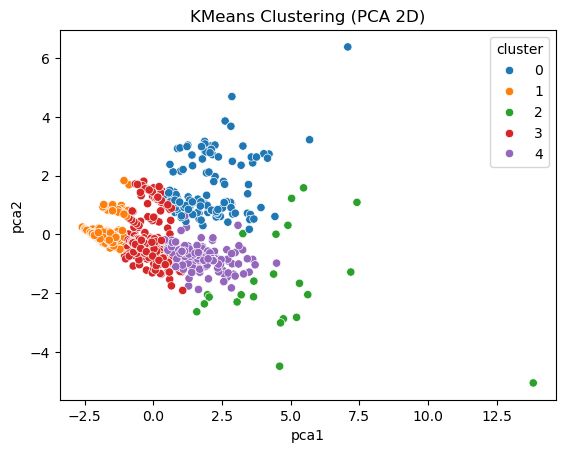

In [47]:
sns.scatterplot(data=df_descriptors, x='pca1', y='pca2', hue='cluster', palette='tab10')
plt.title("KMeans Clustering (PCA 2D)")
plt.show()

next lets explore UMAP. UMAP is a dimensionality reduction technique that is used for visualization of high-dimensional data
take the list of dictionaries we created earlier, and create another dataframe from it.
use this new dataframe to create a UMAP plot with 2 dimensions
set the umap parameters to n_neighbors = 15, min_dist = 0.1, n_components = 2
when making the umap plot, set a color bar as the Tg values from the original dataframe

C:\Users\JEREMIASZ\miniconda3\envs\rdkit-env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


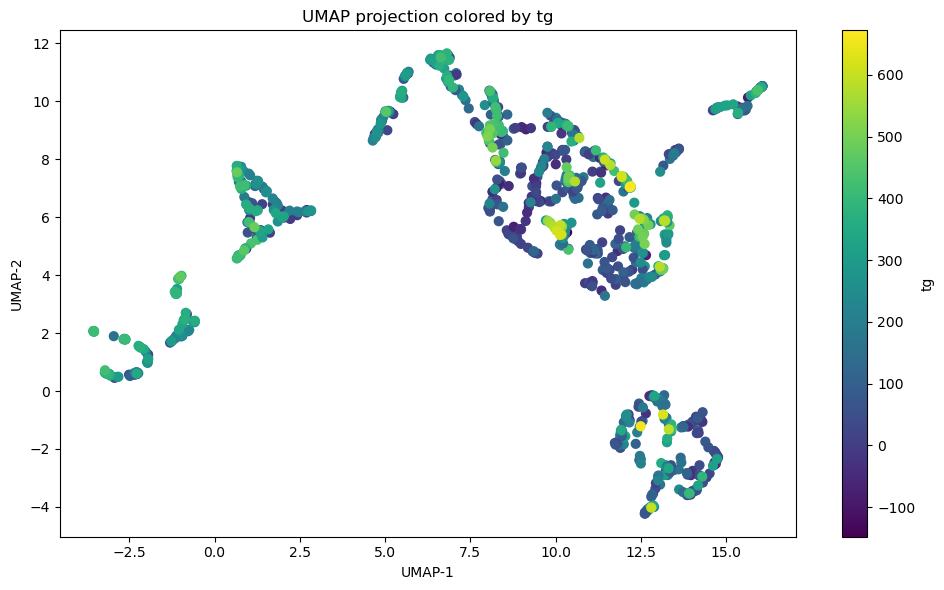

In [39]:
# 4. UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
result = reducer.fit_transform(X)

# 5. Tworzymy DataFrame z wynikami UMAP + Tg
df_descriptors2 = pd.DataFrame(result, columns=['UMAP_1', 'UMAP_2'])
df_descriptors2['tg'] = df['tg']

# 6. Rysujemy
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_descriptors2['UMAP_1'], df_descriptors2['UMAP_2'],
                      c=df_descriptors2['tg'], cmap='viridis', s=40)
plt.colorbar(scatter, label='tg')
plt.title('UMAP projection colored by tg')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.tight_layout()
plt.show()

In [40]:
print(df_descriptors2)

        UMAP_1    UMAP_2          tg
0    14.105955 -1.029610   21.581731
1    13.484386 -2.719054   63.589338
2    14.016632 -1.048377   53.557261
3    12.854705 -3.544144    5.896093
4     1.757104  6.550257  -55.378610
..         ...       ...         ...
959  10.128443  5.386994  618.000000
960  13.147150 -0.811939  624.000000
961  12.200635  7.069783  645.000000
962  12.492329 -1.215443  658.000000
963  12.170451  7.034610  672.000000

[964 rows x 3 columns]


next, create a train test split of the data, using the featurized dataset and the Tg values
set the test_size =0.3 and a random_state = 42
traina linear model (ridge regression) and a non-linear model (random forest) on the training data
test the mdoels on the test set and print the r2 and rmse score for each model
create 2 parity plots, one for each model
In either of these parity plots, can you spot a clear outlier in the model?
if we were to remove this outlier, would our model improve?

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, tg_values, test_size=0.3, random_state=42)

#model liniowy
ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
r2_ridge = r2_score(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

#model nieliniowy
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Ridge Regression")
print(f"  R²:   {r2_ridge:.3f}")
print(f"  RMSE: {rmse_ridge:.3f}")

print("\nRandom Forest")
print(f"  R²:   {r2_rf:.3f}")
print(f"  RMSE: {rmse_rf:.3f}")

# 5. Parity Plots
plt.figure(figsize=(12, 5))

# Ridge plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_ridge, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Tg")
plt.ylabel("Predicted Tg")
plt.title("Parity Plot - Ridge Regression")
plt.grid(True)

# Random Forest plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Tg")
plt.ylabel("Predicted Tg")
plt.title("Parity Plot - Random Forest")
plt.grid(True)

plt.tight_layout()
plt.show()

NameError: name 'tg_values' is not defined

In [1]:
# Model liniowy – Ridge
ridge = Ridge()
ridge.fit(X_train, y_train)
y_train_pred = ridge.predict(X_train)  
rmse_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred))
threshold_ridge = 10 * rmse_ridge

# Reszty i maska 
errors_ridge = np.abs(y_train - y_train_pred)
inlier_mask = errors_ridge <= threshold_ridge


X_train_clean = X_train[inlier_mask]
y_train_clean = y_train[inlier_mask]

# Ridge po oczyszczeniu
ridge_clean = Ridge()
ridge_clean.fit(X_train_clean, y_train_clean)
y_pred_ridge_clean = ridge_clean.predict(X_test)
r2_ridge_clean = r2_score(y_test, y_pred_ridge_clean)
rmse_ridge_clean = np.sqrt(mean_squared_error(y_test, y_pred_ridge_clean))

# Wyniki po usunięciu outlierów
print("\nPo usunięciu outlierów:")
print("Ridge Regression (cleaned)")
print(f"  R²:   {r2_ridge_clean:.3f}")
print(f"  RMSE: {rmse_ridge_clean:.3f}")

# Wykres
def plot_parity(y_true, y_pred, title):
    plt.scatter(y_true, y_pred, alpha=0.7, edgecolors='k')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual Tg")
    plt.ylabel("Predicted Tg")
    plt.title(title)
    plt.grid(True)

plt.figure(figsize=(12, 5))
plot_parity(y_test, y_pred_ridge_clean, "Parity Plot - Ridge (cleaned)")
plt.tight_layout()
plt.show()

NameError: name 'Ridge' is not defined


Po usunięciu outlierów:

Random Forest (cleaned)
  R²:   0.401
  RMSE: 131.229


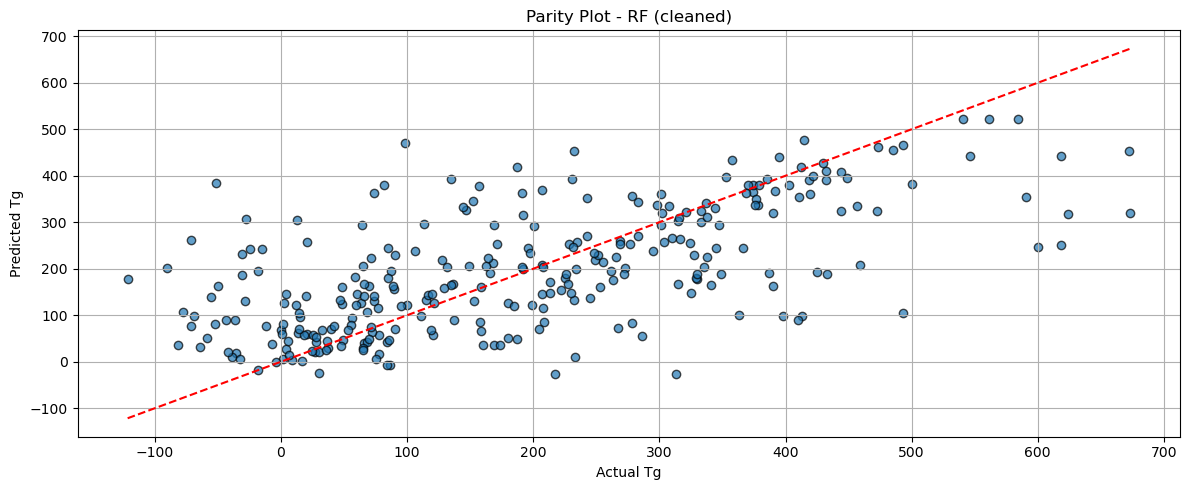

In [60]:
# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_train_pred_rf = rf.predict(X_train)  # <-- Dane treningowe
rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
threshold_rf = 2 * rmse_rf

# Maski dla danych treningowych
errors_rf = np.abs(y_train - y_train_pred_rf)
inlier_mask_rf = errors_rf <= threshold_rf

# Czyścimy dane treningowe
X_train_clean_rf = X_train[inlier_mask_rf]
y_train_clean_rf = y_train[inlier_mask_rf]

# RF po oczyszczeniu
rf_clean = RandomForestRegressor(random_state=42)
rf_clean.fit(X_train_clean_rf, y_train_clean_rf)
y_pred_rf_clean = rf_clean.predict(X_test)
r2_rf_clean = r2_score(y_test, y_pred_rf_clean)
rmse_rf_clean = np.sqrt(mean_squared_error(y_test, y_pred_rf_clean))

# Wyniki po usunięciu outlierów
print("\nPo usunięciu outlierów:")
print("\nRandom Forest (cleaned)")
print(f"  R²:   {r2_rf_clean:.3f}")
print(f"  RMSE: {rmse_rf_clean:.3f}")

# Wykresy parity dla porównania
def plot_parity(y_true, y_pred, title):
    plt.scatter(y_true, y_pred, alpha=0.7, edgecolors='k')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual Tg")
    plt.ylabel("Predicted Tg")
    plt.title(title)
    plt.grid(True)

plt.figure(figsize=(12, 5))
plot_parity(y_test, y_pred_rf_clean, "Parity Plot - RF (cleaned)")
plt.tight_layout()
plt.show()

next, lets see if using gridsearchcv can improve the performance of the models.
repeat the above excerise, but this time use gridsearchcv to find the best hyperparameters for the models
for the ridge model set the param_grid for alpha to alpha = [0.01, 0.1, 1.0, 10, 100], set cv =5, scoring= r^2 and n_jobs = -1.
For the random forest model use this param_grid to search through param_grid_rf = {
'n_estimators': [50, 100, 200],
'max_depth': [None, 5, 10],}
print the best score and the best parameters for each model
create a model from the best parameters and test the model on the test set
do you see an improvement in the performance of the models?

In [61]:
# Parametry dla Ridge
param_grid_ridge = {
    'alpha': [0.01, 0.1, 1.0, 10, 100]
}

# Parametry dla Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10]
}


ridge_grid = GridSearchCV(Ridge(), param_grid_ridge, cv=5, scoring='r2', n_jobs=-1)
ridge_grid.fit(X_train, y_train)

print("Ridge - Najlepszy R²:", ridge_grid.best_score_)
print("Ridge - Najlepsze parametry:", ridge_grid.best_params_)

# Testowanie Ridge z najlepszymi parametrami
best_ridge = ridge_grid.best_estimator_
y_pred_ridge_tuned = best_ridge.predict(X_test)
r2_ridge_tuned = r2_score(y_test, y_pred_ridge_tuned)
rmse_ridge_tuned = np.sqrt(mean_squared_error(y_test, y_pred_ridge_tuned))


rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
rf_grid.fit(X_train, y_train)

print("\nRF - Najlepszy R²:", rf_grid.best_score_)
print("RF - Najlepsze parametry:", rf_grid.best_params_)


best_rf = rf_grid.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test)
r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)
rmse_rf_tuned = np.sqrt(mean_squared_error(y_test, y_pred_rf_tuned))

Ridge - Najlepszy R²: 0.275663872481999
Ridge - Najlepsze parametry: {'alpha': 1.0}

RF - Najlepszy R²: 0.4200719918489762
RF - Najlepsze parametry: {'max_depth': 10, 'n_estimators': 200}


In [62]:
print("\nPorównanie wyników:")

print("\nRidge Regression (przed tuningiem):")
print(f"  R²: {r2_ridge:.3f}")
print(f"  RMSE: {rmse_ridge:.3f}")

print("\nRidge Regression (po tuningu):")
print(f"  R²: {r2_ridge_tuned:.3f}")
print(f"  RMSE: {rmse_ridge_tuned:.3f}")

print("\nRandom Forest (przed tuningiem):")
print(f"  R²: {r2_rf:.3f}")
print(f"  RMSE: {rmse_rf:.3f}")

print("\nRandom Forest (po tuningu):")
print(f"  R²: {r2_rf_tuned:.3f}")
print(f"  RMSE: {rmse_rf_tuned:.3f}")


Porównanie wyników:

Ridge Regression (przed tuningiem):
  R²: 0.207
  RMSE: 133.152

Ridge Regression (po tuningu):
  R²: 0.207
  RMSE: 150.953

Random Forest (przed tuningiem):
  R²: 0.429
  RMSE: 49.196

Random Forest (po tuningu):
  R²: 0.438
  RMSE: 127.112


Wyższy RMSE w obu modelach oznacza, że stały się mniej precyzyjne w przewidywaniu wartości bezwzględnych. 
Tuning mógł spowodować "przeuczenie" modelu podczas walidacji krzyżowej. 

next, lets generate features from the get_morgan_fingerprint function
create one list called morgan_fingerprints of the morgan fingerprints for each smiles string in the dataset
next, create a new dataframe from the morgan_fingerprints list
next, split the data set into a test and train set using the Tg values as your target variable,
set the test_size = 0.3 and random_state = 42
standardize the data using the StandardScaler, and train a linear ridge(alpha=0.1) model and a non-linear random forest(n_estimators=100,random_state=42) model
test the models on the test set and print the r2 and rmse score for each model
plot a parity plot for each model

In [67]:
morgan_fingerprints = []

for idx, smiles in enumerate(df_unique['SMILES']):
    fp = get_morgan_fingerprint(smiles)
    if fp is not None:
        features_list.append(desc)
        morgan_fingerprints.append(fp)

X_morgan = pd.DataFrame(morgan_fingerprints)
X_combined = pd.concat([df_descriptors, X_morgan], axis=1)

Ridge Regression
  R²: -4.903
  RMSE: 411.811

Random Forest
  R²: 0.569
  RMSE: 111.332


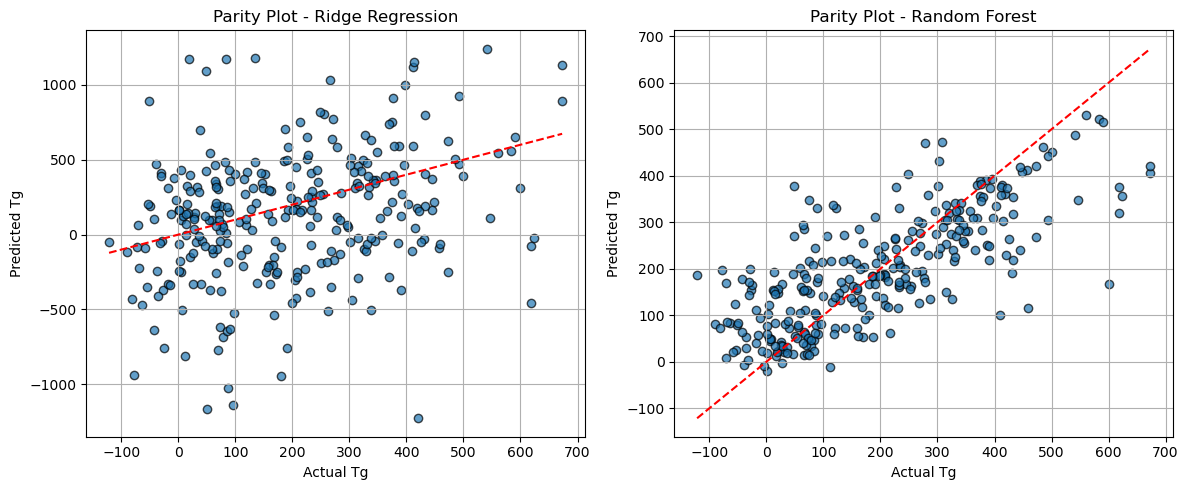

In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, tg_values, test_size=0.3, random_state=42
)

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Trenowanie modelu Ridge (liniowy)
ridge = Ridge(alpha=0.1)
ridge.fit(X_train_scaled, y_train)

# Predykcje Ridge na zbiorze testowym
y_pred_ridge = ridge.predict(X_test_scaled)

# Metryki Ridge
r2_ridge = r2_score(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

print("Ridge Regression")
print(f"  R²: {r2_ridge:.3f}")
print(f"  RMSE: {rmse_ridge:.3f}")

# 3. Trenowanie modelu Random Forest (nieliniowy)
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)

# Predykcje Random Forest na zbiorze testowym
y_pred_rf = rf.predict(X_test_scaled)

# Metryki Random Forest
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("\nRandom Forest")
print(f"  R²: {r2_rf:.3f}")
print(f"  RMSE: {rmse_rf:.3f}")


def plot_parity(y_true, y_pred, title):
    plt.scatter(y_true, y_pred, alpha=0.7, edgecolors='k')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual Tg")
    plt.ylabel("Predicted Tg")
    plt.title(title)
    plt.grid(True)


plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plot_parity(y_test, y_pred_ridge, "Parity Plot - Ridge Regression")


plt.subplot(1, 2, 2)
plot_parity(y_test, y_pred_rf, "Parity Plot - Random Forest")

plt.tight_layout()
plt.show()

next lets use the get_topological_fingerprint function to generate 2D structural features of our smiles strings
create a list called topological_fps of the topological fingerprints for each smiles string in the dataset
and convert this to a dataframe. Create a train test split of the data using the Tg values as the target variable
set the test_size = 0.3 and random_state = 42.
for this excercise we are going to train a Support vector regression and a random forest model.
We will also want to create a 3rd model called ensemble made up of both of the models.
using the VotingRegressor from sklearn.ensemble, create a model that combines the SVR and random forest models.
test each model, print the r2 and rmse score for each all 3 models as well as a parity plot for each model.
Do we see any improvement in the performance of the models when we combine into an ensemble of models?

In [74]:
topological_fps = []  # Lista na topologiczne fingerprinty
valid_indices = []    # Indeksy poprawnych SMILES-ów

for idx, smiles in enumerate(df_unique['SMILES']):
    fp = get_topological_fingerprint(smiles)  # Generuj topologiczny fingerprint
    if fp is not None:
        topological_fps.append(fp)
        valid_indices.append(idx)

X_topological = pd.DataFrame(topological_fps)
X_combined = pd.concat([df_descriptors, X_topological], axis=1)

tg_values_valid = tg_values[valid_indices]


X_train, X_test, y_train, y_test = train_test_split(
    X_combined, tg_values_valid, test_size=0.3, random_state=42
)

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

Support Vector Regression
  R²: 0.004
  RMSE: 169.200

Random Forest
  R²: 0.419
  RMSE: 129.230

Ensemble Model (SVR + RF)
  R²: 0.356
  RMSE: 136.033


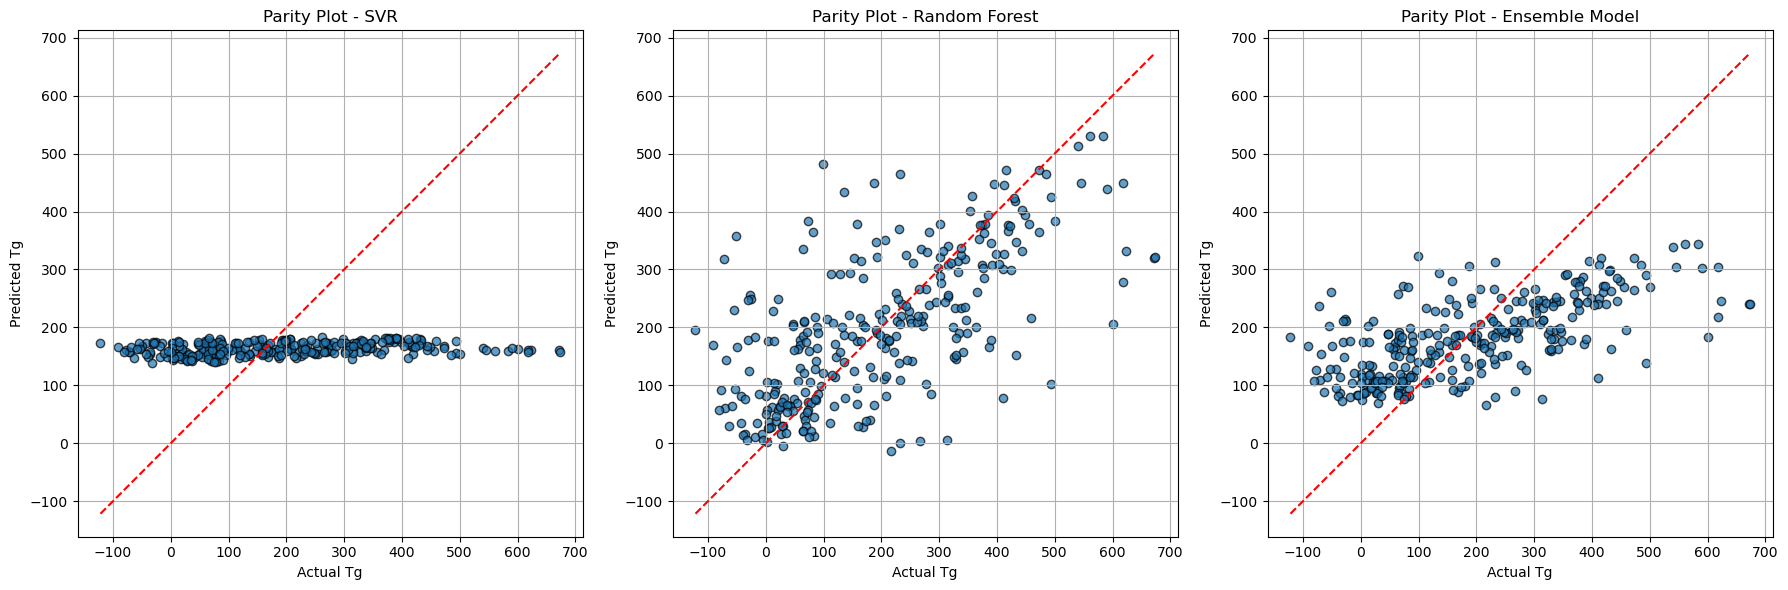

In [75]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 8. Model 1: Support Vector Regression (SVR)
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr.fit(X_train_scaled, y_train)
y_pred_svr = svr.predict(X_test_scaled)
r2_svr = r2_score(y_test, y_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))

print("Support Vector Regression")
print(f"  R²: {r2_svr:.3f}")
print(f"  RMSE: {rmse_svr:.3f}")

# 9. Model 2: Random Forest (RF)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("\nRandom Forest")
print(f"  R²: {r2_rf:.3f}")
print(f"  RMSE: {rmse_rf:.3f}")

# 10. Model 3: Ensemble Model (SVR + RF)
ensemble = VotingRegressor(estimators=[('svr', svr), ('rf', rf)])
ensemble.fit(X_train_scaled, y_train)
y_pred_ensemble = ensemble.predict(X_test_scaled)
r2_ensemble = r2_score(y_test, y_pred_ensemble)
rmse_ensemble = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))

print("\nEnsemble Model (SVR + RF)")
print(f"  R²: {r2_ensemble:.3f}")
print(f"  RMSE: {rmse_ensemble:.3f}")

# 11. Parity Plots
def plot_parity(y_true, y_pred, title):
    plt.scatter(y_true, y_pred, alpha=0.7, edgecolors='k')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual Tg")
    plt.ylabel("Predicted Tg")
    plt.title(title)
    plt.grid(True)

plt.figure(figsize=(18, 6))

# SVR plot
plt.subplot(1, 3, 1)
plot_parity(y_test, y_pred_svr, "Parity Plot - SVR")

# Random Forest plot
plt.subplot(1, 3, 2)
plot_parity(y_test, y_pred_rf, "Parity Plot - Random Forest")

# Ensemble plot
plt.subplot(1, 3, 3)
plot_parity(y_test, y_pred_ensemble, "Parity Plot - Ensemble Model")

plt.tight_layout()
plt.show()

nie jest lepiej

for the final excercise, we are going to identify the most similar molecules in our dataset relative to the first molecule in the dataset.
so we want to compare how similar the first molecule is to the rest of the molecules in the dataset
generate morgan fingerprints for the first molecule in the dataset and compare it to the rest of the molecules in the dataset
you'll first generate morgan fingerprints(radius=2, nBits=1024) for the first molecule in the dataset
and then for the rest of the molecules in the dataset. Calulate the Tanimoto similarity between the first molecule and the rest of the molecules in the dataset, print the top 10 most similar molecules to the first molecule in the dataset
it should look something like this:
Most similar molecules:
SMILES Similarity
0 *C1COC2C1OCC2Oc1ccc(cc1)CNC(=O)CCCCCCC(=O)NCc1... 1.000000
222 *N=Occ1 0.444444
333 *Oc1cCC(=O)NCCCc1cccOC... 0.428571
444 *C1C2OC(=O)CCC(=O)O 0.428571
20 *NC.... 0.425926
12 *OC(=O)CNC... 0.353846
use MolsToGridImage to display the molecule and the 4 most similar molecules to the first molecule in the dataset.

Most similar molecules:
Index SMILES                                                                 Similarity
0     *C1COC2C1OCC2Oc1ccc(cc1)CNC(=O)CCCCCCC(=O)NCc1ccc(cc1)O*               1.000000
854   *NCc1ccc(CNC(=O)CCCCCCCCC(*)=O)cc1                                     0.444444
502   *Oc1ccc(cc1)CCCNC(=O)CCCCC(=O)NCCCc1ccc(cc1)OCCCCC*                    0.428571
629   *C1COC2C1OCC2OC(=O)CCC(=O)O*                                           0.428571
201   *NC(=O)CCCCCC(=O)NCc1ccc(cc1)C*                                        0.425926
2     *OC(=O)c1ccc(cc1)C(=O)OCCCC(=O)NCc1ccc(cc1)CNC(=O)CCC*                 0.353846
824   *NCc1cccc(CNC(=O)CCCCC(*)=O)c1                                         0.350000
379   *Oc1ccc(cc1)OC(=O)CCCCCCCC(=O)*                                        0.333333
105   *Oc1ccc(cc1)NC(=O)NCCCCCCNC(=O)*                                       0.322581
491   *Oc1ccc(cc1)C(=O)CCCCCCCCC(=O)c1ccc(cc1)OC(=O)*                        0.316667


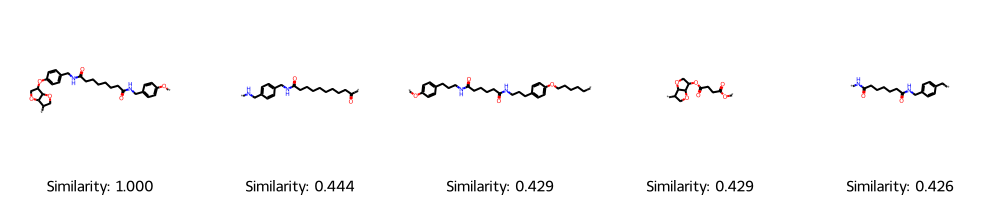

In [78]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem.Draw import MolsToGridImage
import pandas as pd


smiles_list = df_unique['SMILES']

# Step 1: Generate Morgan Fingerprint for the first molecule
first_smiles = smiles_list[0]
first_mol = Chem.MolFromSmiles(first_smiles)
first_fp = AllChem.GetMorganFingerprintAsBitVect(first_mol, radius=2, nBits=1024)

# Step 2: Generate Morgan Fingerprints for the rest of the molecules and calculate Tanimoto similarity
similarities = []
for idx, smiles in enumerate(smiles_list):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
        similarity = DataStructs.TanimotoSimilarity(first_fp, fp)
        similarities.append((idx, smiles, similarity))

# Step 3: Sort molecules by similarity (descending order)
similarities.sort(key=lambda x: x[2], reverse=True)

# Step 4: Print the top 10 most similar molecules
print("Most similar molecules:")
print(f"{'Index':<5} {'SMILES':<70} {'Similarity'}")
for idx, smiles, similarity in similarities[:10]:
    print(f"{idx:<5} {smiles[:70]:<70} {similarity:.6f}")

# Step 5: Visualize the first molecule and the 4 most similar molecules
top_molecules_indices = [idx for idx, _, _ in similarities[:5]]  # First molecule + 4 most similar
mols_to_draw = [Chem.MolFromSmiles(smiles_list[i]) for i in top_molecules_indices]

# Use MolsToGridImage to display the molecules
img = MolsToGridImage(
    mols_to_draw,
    legends=[f"Similarity: {similarities[i][2]:.3f}" for i in range(5)],
    molsPerRow=5,
    subImgSize=(200, 200)
)
display(img)